**Please insert your full name:** Alireza Dehghanpour Farashah

**And your student number:** 98101555



---



# Q1 (Sharpening)


## Import dependencies:

In [1]:
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt
import time

from scipy.ndimage import gaussian_filter, gaussian_laplace
from scipy import signal

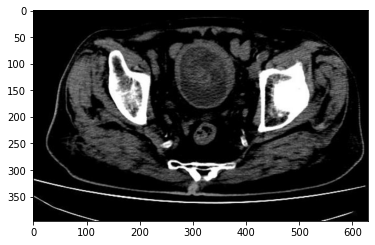

In [2]:
img = plt.imread('image1.jpeg', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32)

def normal(res):
    return (res - res.min()) / (res.max() - res.min())

img = normal(img)
plt.imshow(img)

## Read the image and use four different methods to sharpen the image. Briefly discuss your main approach in each of the methods.

You are allowed to use any kind of different methods. The recommanded ones are as follow:

1) unsharp mask filter

2) second deriative or guassian laplacian

3) unsharp mask in frequency domain

4) laplacian in frequency domain , sharpening with laplacian

## First Method

In this method at first we apply a gaussian filter which makes our image smooth, then we subtract the smoothed image from the original. The result is edges of the image. We add the sharpened with the original image by a multiplying to a constant alpha.

--- 0.04601263999938965 seconds ---


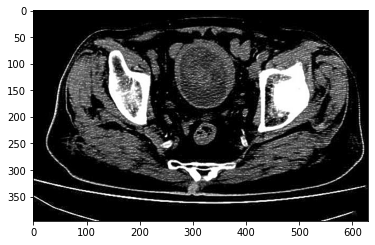

In [3]:
def unsharp_mask(img):
    blured_img = gaussian_filter(img, sigma=1, truncate=4)
    blured_img = np.clip(blured_img, 0, 1)
    # plt.imshow(blured_img)
    # plt.show()
    sharpened = img - blured_img
    sharpened = np.clip(sharpened, 0, 1)
    # plt.imshow(sharpened)
    # plt.show()
    return np.clip(img + 5*sharpened, 0, 1)

start_time = time.time()
um = unsharp_mask(img)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(um)
plt.savefig("unsharp_mask.png")

## Second Method

In this method by calculating the second derivative of the image we get the edges of the image.
$$\nabla^2 f = \frac{\partial^2 f(x,y)}{\partial x^2} + \frac{\partial^2 f(x,y)}{\partial y^2} $$
By adding the edges with the original image we get a sharp image.


--- 0.0768735408782959 seconds ---


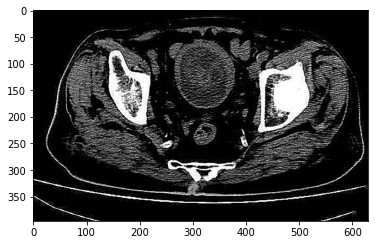

In [4]:
def second_derivative(image):
    kernel = np.zeros((5,5))
    kernel[2,2] = 2
    kernel = scipy.ndimage.filters.laplace(kernel)
    lp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    # plt.imshow(np.clip(lp, 0, 1))
    # plt.show()
    res = image - 1*lp
    return np.clip(res, 0, 1)
    
start_time = time.time()
sd = second_derivative(img)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(sd,cmap='gray')
plt.savefig("second_derivative.png")

## Third Method

This method is same as the first one with the diffrenece of domain that we work. In this part we sharpen our image in frequency domain by multiplying a high-pass filter in frequency domain.
Here is the formula in HW2 pdf:
$$S = \mathcal{F}^{-1}\{1+k[1-lf].\mathcal{F}\}$$
in which lf is low-pass filter.

--- 0.7559478282928467 seconds ---


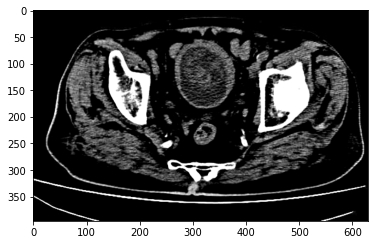

In [5]:

def highpass_filter(img, x_lim=10, y_lim=10):
    hf = np.ones(img.shape[0:2])
    rows, cols = img.shape
    crow,ccol = rows/2 , cols/2
    crow = np.int32(crow)
    ccol = np.int32(ccol)
    hf[(crow-x_lim):(crow+x_lim+1), (ccol-y_lim):(ccol+y_lim+1)] = 0 
    hf = gaussian_filter(hf, sigma=1)
    return hf


def lowpass_filter(img, r=10):
    rows, cols = img.shape
    lf = np.zeros((rows,cols), dtype=np.float32)
    for u in range(rows):
        for v in range(cols):
            d = np.sqrt((u-rows/2)**2 + (v-cols/2)**2)
            lf[u,v] = np.exp(-d**2/(2*r**2))
    return lf

def unsharp_frequency_domain(img):
    k = 1
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    
    hf = highpass_filter(img, 10, 10)
    lf = lowpass_filter(img)
    fshift = (k * (1.0-lf) + 1) * fshift
    
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.real(img_back)
    return np.clip(img_back, 0, 1)


I = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
start_time = time.time()
ufd = unsharp_frequency_domain(I)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(ufd, cmap='gray')
plt.savefig("unsharp_mask_freq_domain.png")

## Forth Method

This method is the same as second one but in frequency domain.
$$S = f + k \mathcal{F}^{-1}\{4\pi^2(u^2+v^2)F(u,v)\}$$
In which F is the fourier transform of the image.
In this code the laplacian filter if the $4\pi^2(u^2+v^2)$ and then I multiply this filter in frequency domain with the fft of image.

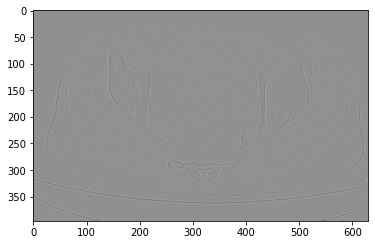

--- 0.29823803901672363 seconds ---


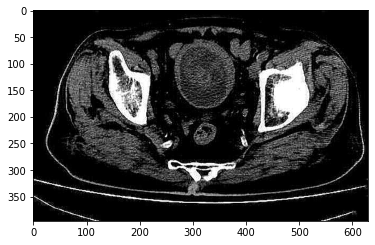

In [6]:
def normal_range(img, lower=-1, upper=1):
    r = np.max(img) - np.min(img)
    return (((img-np.min(img))*(upper-lower))/r) + lower
    
def laplacian_filter(img):
    rows, cols = img.shape
    lf = np.zeros((rows,cols), dtype=np.float32)
    for u in range(rows):
        for v in range(cols):
            lf[u,v] = -4*np.pi*np.pi*((u-rows/2)**2 + (v-cols/2)**2)
    return lf
            
def laplace_frequency_domain(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    lf = laplacian_filter(img)
    lp = lf * fshift
    lp = np.fft.ifftshift(lp)
    lp = np.real(np.fft.ifft2(lp))
    # lp = normal_range(lp)
    # lp = np.clip(lp, 0, 1)
    plt.imshow(lp,cmap='gray')
    plt.show()
    return lp


start_time = time.time()
I = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lp = laplace_frequency_domain(I)     
k = 5e-6
I = I - k*lp
I = np.clip(I, 0, 1)  
plt.imshow(I, cmap='gray')
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.savefig("laplace_freq_domain.png")

### Compare different methods quality and time.

The execution time depends on the filter size and other parameters. The third and fourth method are slower and the fisrt and second one are faster.
The best results are for the fourth method. 
To conclude, there is a trade-off between the execution time and the quality of sharpening.

# Q2(Filtering)

## Import dependencies:

In [7]:
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter, gaussian_laplace
from scipy import signal

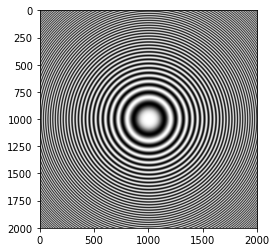

In [8]:
img = cv2.imread('image2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img/255.0
plt.imshow(img, cmap='gray')

## Section 1

#### Sobel

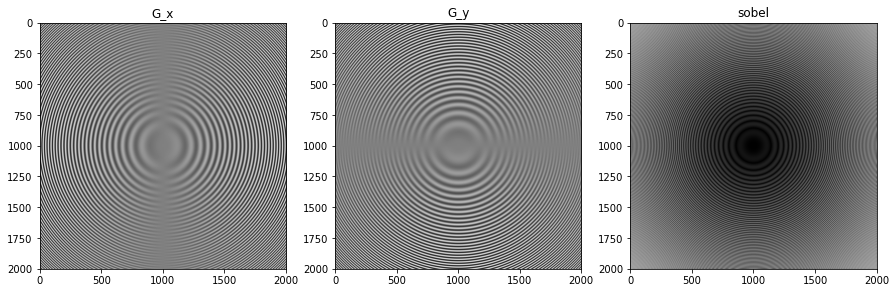

In [9]:
s_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
s_y = s_x.T
G_x = cv2.filter2D(src=img, ddepth=-1, kernel=s_x)
G_y = cv2.filter2D(src=img, ddepth=-1, kernel=s_y)

G = np.hypot(G_x, G_y)
G = G / G.max()

f, ax = plt.subplots(1,3, figsize=(15, 15))
ax[0].imshow(G_x,cmap='gray')
ax[0].set_title("G_x")
ax[1].imshow(G_y,cmap='gray')
ax[1].set_title("G_y")
ax[2].imshow(G, cmap='gray')
ax[2].set_title("sobel")
plt.savefig("q2_res01.png")

#### gaussian

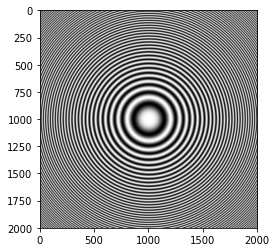

In [10]:
kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
res = cv2.filter2D(src=img, ddepth=-1, kernel=1.0/16*kernel)
plt.imshow(res,cmap='gray')
plt.savefig("q2_res02.png")

#### laplacian

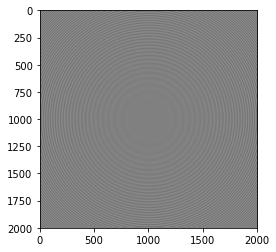

In [11]:
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
res = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
plt.imshow(res,cmap='gray')
plt.savefig("q2_res03.png")

### Compare different methods.

**Sobel:**
In order to compare these methods, the fisrt method at fisrt compute the vertical and horizontal edges, then it merges these two results and sharpen edges in image.

**Gaussian:**
It applies a low-pass filter on the image and it keeps lower frequencies. Therefore, the output becomes blured, but here because our filter size is small it doesn't clear so much.

**laplacian:**
This filter is estimate the second derivative of the image and it calculates the edges of the image.

## Section 2

the MSE between the estimated and target filter is:  7.773346593442044e-05


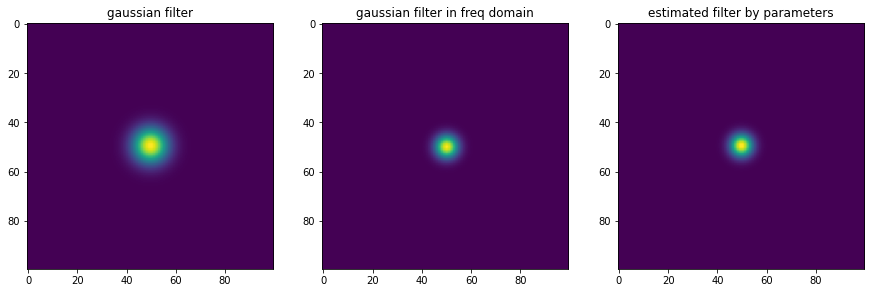

In [12]:
#here we show fourier transform of a gaussian signal is also gaussian with sigma2 = 1/(2*pi*sigma1)

import numpy as np
# source https://dsp.stackexchange.com/questions/83045/fft-of-a-gaussian-signal-in-python
# in the frequenct domain the sigma is [1/(2*pi*simga)]

f, ax = plt.subplots(1,3, figsize=(15, 15))

grid_x, grid_y = np.mgrid[-5:5:100j, -5:5:100j]
x_0, y_0 = 0, 0 
sigma = 0.5
sigma_x, sigma_y = sigma, sigma
A = 1.0/(2*np.pi*0.25) 
lf = A * np.exp(-(((grid_x - x_0)**2 / (2 * sigma_x**2)) + ((grid_y - y_0)**2 / (2 * sigma_y**2))))
ax[0].imshow(lf)
ax[0].set_title("gaussian filter")

NFFT = 100.0
f = np.fft.fft2(lf,(NFFT, NFFT))
fshift = np.fft.fftshift(f)
magnitude_spectrum = (np.abs(fshift)/NFFT)
ax[1].imshow(magnitude_spectrum)
ax[1].set_title("gaussian filter in freq domain")

grid_x, grid_y = np.mgrid[-5:5:100j, -5:5:100j]
A = 1 
x_0, y_0 = 0, 0 
sigma_x, sigma_y = 1.0/(2*np.pi*sigma), 1.0/(2*np.pi*sigma)
gaussian_2D = A * np.exp(-(((grid_x - x_0)**2 / (2 * sigma_x**2)) + ((grid_y - y_0)**2 / (2 * sigma_y**2))))
ax[2].imshow(gaussian_2D)
ax[2].set_title("estimated filter by parameters")

MSE = np.square(np.subtract(abs(fshift)/NFFT,gaussian_2D)).mean()
print("the MSE between the estimated and target filter is: ", MSE)

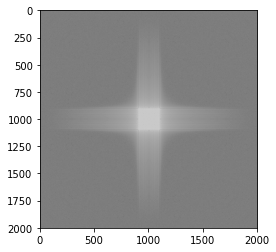

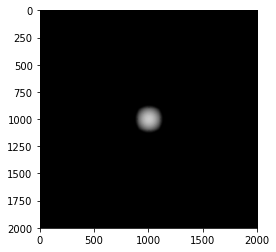

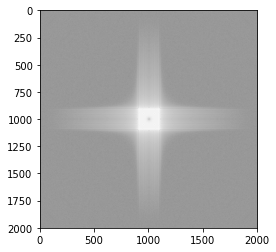

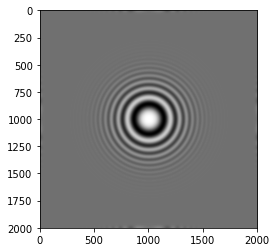

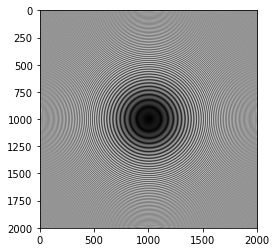

<Figure size 432x288 with 0 Axes>

In [13]:
def show_image(image, ax=None):
    plt.imshow(image, cmap='gray')
    plt.show()
    
def lowpass_filter(img, r=10):
    rows, cols = img.shape
    lf = np.zeros((rows,cols), dtype=np.float32)
    for u in range(rows):
        for v in range(cols):
            d = np.sqrt((u-rows/2)**2 + (v-cols/2)**2)
            lf[u,v] = np.exp(-d**2/(2*r**2))
    return lf

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift) + 1e-6)
show_image(magnitude_spectrum)
plt.savefig("q2_res04.png")

low_filter = lowpass_filter(img, 20)
filtered_img = fshift*low_filter
filtered_img_spec = 20*np.log(np.abs(filtered_img) + 1e-6)
show_image(filtered_img_spec)
plt.savefig("q2_res05.png")

filtered_img2 = fshift*(1-low_filter)
filtered_img_spec2 = 20*np.log(np.abs(filtered_img2) + 1e-6)
show_image(filtered_img_spec2)
plt.savefig("q2_res06.png")

f_ishift = np.fft.ifftshift(filtered_img)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)
show_image(img_back)
plt.savefig("q2_res07.png")

f_ishift = np.fft.ifftshift(filtered_img2)
img_back = np.fft.ifft2(f_ishift)
img_back = abs(img_back)
show_image(img_back)
plt.savefig("q2_res08.png")

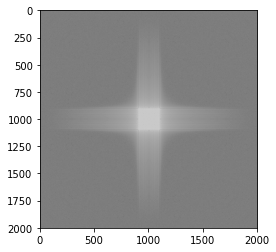

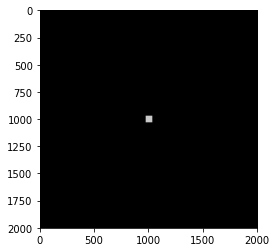

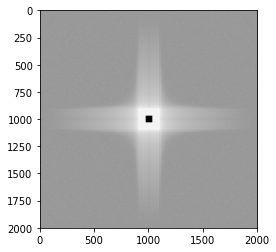

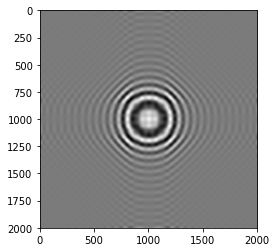

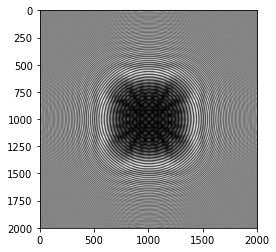

<Figure size 432x288 with 0 Axes>

In [14]:
def show_image(image, ax=None):
    plt.imshow(image, cmap='gray')
    plt.show()
    
def square_filter(img, r=20):
    rows, cols = img.shape
    sf = np.zeros((rows,cols), dtype=np.float32)
    crow,ccol = rows/2 , cols/2
    crow = np.int32(crow)
    ccol = np.int32(ccol)
    sf[(crow-r):(crow+r+1), (ccol-r):(ccol+r+1)] = 1
    return sf

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift) + 1e-6)
show_image(magnitude_spectrum)


square_filter = square_filter(img, 30)
filtered_img = fshift*square_filter
filtered_img_spec = 20*np.log(np.abs(filtered_img) + 1e-6)
show_image(filtered_img_spec)
plt.savefig("q2_res09.png")

filtered_img2 = fshift*(1-square_filter)
filtered_img_spec2 = 20*np.log(np.abs(filtered_img2) + 1e-6)
show_image(filtered_img_spec2)
plt.savefig("q2_res10.png")

f_ishift = np.fft.ifftshift(filtered_img)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)
show_image(img_back)
plt.savefig("q2_res11.png")

f_ishift = np.fft.ifftshift(filtered_img2)
img_back = np.fft.ifft2(f_ishift)
img_back = abs(img_back)
show_image(img_back)
plt.savefig("q2_res12.png")

## Compare and contrast results
In the both these method we apply a lowpass filter and $1-lf$ which is equal a high-pass filter. 
The small squares in the second method are because of multiplying all high frequencies in a same constant number. Consider a point in frequency domain with $(w, w)$, we enhance this frequency in $x$ and $y$ direction but the point $(w, 0)$ and $(0, w)$ is not in the square filter, so the edges in $x$ pivot and $y$ pivot enhance more than edges in directions such as $y=x$ line.